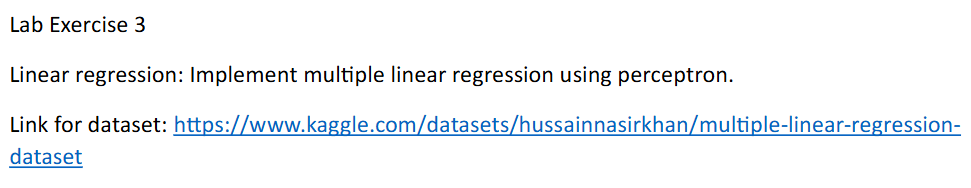

# Linear Regression: Implement multiple linear regression using perceptron

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_csv(r'inputs\multiple_linear_regression_dataset.csv')

print("Multiple Linear Regression - Perceptron (PyTorch)")
print(f"\nDataset: {df.shape[0]} samples, {df.shape[1]} columns")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst rows:\n{df.head()}")
print(f"\nData info:\n{df.describe()}")

# Identify target column (income or last column)
cols = df.columns.tolist()
if 'income' in cols:
    target_col = 'income'
elif any('income' in col.lower() for col in cols):
    target_col = [col for col in cols if 'income' in col.lower()][0]
else:
    target_col = cols[-1]

print(f"\nTarget column: {target_col}")

# Handle categorical variables
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
if cat_cols:
    print(f"Encoding categorical: {cat_cols}")
    df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

print(f"After encoding: {df.shape}")

# Separate features and target
X = df.drop(target_col, axis=1).values
y = df[target_col].values.reshape(-1, 1)

print(f"Features: {X.shape}, Target: {y.shape}")

# Split data
x_tr, x_ts, y_tr, y_ts = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Scale features and target
scale_x = StandardScaler()
scale_y = StandardScaler()

x_tr = scale_x.fit_transform(x_tr)
x_ts = scale_x.transform(x_ts)
y_tr = scale_y.fit_transform(y_tr)
y_ts = scale_y.transform(y_ts)

print(f"Train: {x_tr.shape[0]}, Test: {x_ts.shape[0]}")

# Convert to tensors
x_tr_t = torch.FloatTensor(x_tr)
y_tr_t = torch.FloatTensor(y_tr)
x_ts_t = torch.FloatTensor(x_ts)
y_ts_t = torch.FloatTensor(y_ts)

# Data loaders
batch = 8
tr_data = TensorDataset(x_tr_t, y_tr_t)
ts_data = TensorDataset(x_ts_t, y_ts_t)
tr_load = DataLoader(tr_data, batch_size=batch, shuffle=True)
ts_load = DataLoader(ts_data, batch_size=batch, shuffle=False)


class LinReg(nn.Module):
    def __init__(self, n_feat):
        super(LinReg, self).__init__()
        self.layer = nn.Linear(n_feat, 1)

    def forward(self, x):
        return self.layer(x)


# Initialize
n_feat = x_tr.shape[1]
model = LinReg(n_feat)
criter = nn.MSELoss()
optim_fn = optim.SGD(model.parameters(), lr=0.1)

print("Architecture")
print(model)
n_param = sum(p.numel() for p in model.parameters())
print(f"\nParams: {n_param}")


def train(model, tr_load, ts_load, criter, optim_fn, epochs=1000):
    hist_loss = []
    hist_val = []

    for ep in range(epochs):
        model.train()
        loss_sum = 0.0

        for inputs, labels in tr_load:
            outputs = model(inputs)
            loss = criter(outputs, labels)

            optim_fn.zero_grad()
            loss.backward()
            optim_fn.step()

            loss_sum += loss.item()

        avg_loss = loss_sum / len(tr_load)
        hist_loss.append(avg_loss)

        # Validation
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in ts_load:
                outputs = model(inputs)
                loss = criter(outputs, labels)
                val_loss += loss.item()

        val_avg = val_loss / len(ts_load)
        hist_val.append(val_avg)

        if (ep + 1) % 100 == 0:
            print(f"Epoch {ep+1:4d} | Train MSE: {avg_loss:.6f} | Val MSE: {val_avg:.6f}")

    return hist_loss, hist_val


# Train
hist_loss, hist_val = train(
    model, tr_load, ts_load, criter, optim_fn, epochs=1000
)

# Predictions
print("Results")

def get_pred(model, loader):
    model.eval()
    preds = []
    actuals = []

    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            preds.append(outputs.cpu().numpy())
            actuals.append(labels.cpu().numpy())

    return np.vstack(preds), np.vstack(actuals)


y_tr_p, y_tr_act = get_pred(model, tr_load)
y_ts_p, y_ts_act = get_pred(model, ts_load)

# Inverse transform
y_tr_pred = scale_y.inverse_transform(y_tr_p)
y_tr_true = scale_y.inverse_transform(y_tr_act)
y_ts_pred = scale_y.inverse_transform(y_ts_p)
y_ts_true = scale_y.inverse_transform(y_ts_act)

# Metrics
tr_mse = mean_squared_error(y_tr_true, y_tr_pred)
ts_mse = mean_squared_error(y_ts_true, y_ts_pred)
tr_rmse = np.sqrt(tr_mse)
ts_rmse = np.sqrt(ts_mse)
tr_mae = mean_absolute_error(y_tr_true, y_tr_pred)
ts_mae = mean_absolute_error(y_ts_true, y_ts_pred)
tr_r2 = r2_score(y_tr_true, y_tr_pred)
ts_r2 = r2_score(y_ts_true, y_ts_pred)

print(f"\nTrain Metrics:")
print(f"  MSE:  {tr_mse:.2f}")
print(f"  RMSE: {tr_rmse:.2f}")
print(f"  MAE:  {tr_mae:.2f}")
print(f"  R2:   {tr_r2:.4f}")

print(f"\nTest Metrics:")
print(f"  MSE:  {ts_mse:.2f}")
print(f"  RMSE: {ts_rmse:.2f}")
print(f"  MAE:  {ts_mae:.2f}")
print(f"  R2:   {ts_r2:.4f}")

# Display sample predictions
print(f"\nSample predictions (first 5 test):")
print(f"{'Actual':<12} {'Predicted':<12} {'Error':<12}")
print("-" * 36)
for i in range(min(5, len(y_ts_true))):
    actual = y_ts_true[i, 0]
    pred = y_ts_pred[i, 0]
    error = abs(actual - pred)
    print(f"{actual:<12.2f} {pred:<12.2f} {error:<12.2f}")

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(hist_loss, label='Train')
axes[0].plot(hist_val, label='Val')
axes[0].set_title('MSE Loss vs Epochs')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('MSE')
axes[0].legend()
axes[0].grid(True)

# Predictions vs Actual
axes[1].scatter(y_ts_true, y_ts_pred, alpha=0.6, label='Test')
axes[1].plot([y_ts_true.min(), y_ts_true.max()], 
             [y_ts_true.min(), y_ts_true.max()], 
             'r--', lw=2, label='Perfect')
axes[1].set_xlabel('Actual')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Predictions vs Actual')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig(r'outputs\linreg_pytorch.png', dpi=300, bbox_inches='tight')
plt.close()

torch.save(model.state_dict(), r'outputs\linreg_model.pth')

print("\nGraph saved: linreg_pytorch.png")
print("Model saved: linreg_model.pth")

Multiple Linear Regression - Perceptron (PyTorch)

Dataset: 20 samples, 3 columns

Columns: ['age', 'experience', 'income']

First rows:
   age  experience  income
0   25           1   30450
1   30           3   35670
2   47           2   31580
3   32           5   40130
4   43          10   47830

Data info:
             age  experience        income
count  20.000000   20.000000     20.000000
mean   39.650000    6.200000  40735.500000
std    10.027725    4.124382   8439.797625
min    23.000000    1.000000  27840.000000
25%    31.500000    3.750000  35452.500000
50%    40.000000    5.000000  40190.000000
75%    47.000000    9.000000  45390.000000
max    58.000000   17.000000  63600.000000

Target column: income
After encoding: (20, 3)
Features: (20, 2), Target: (20, 1)
Train: 16, Test: 4

Architecture
LinReg(
  (layer): Linear(in_features=2, out_features=1, bias=True)
)

Params: 3

Training
Epoch  100 | Train MSE: 0.028111 | Val MSE: 0.010880
Epoch  200 | Train MSE: 0.026409 | Val MSE: